### Carga de Base de datos y Librerias

In [1]:
# Cargamos todas las librerias que vamos a necesitar y abrimos la ruta al repositorio

# PARTE 1
!pip install openpyxl
!pip install matplotlib pandas
!pip install pandas pyreadstat
!pip install pandas numpy scikit-learn matplotlib
!pip install seaborn

import pandas as pd
import os # Exportamos este módulo para trabajar con carpetas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# PARTE 2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score


#Cargamos el archivo desde el directorio del GitHub
base_dir = os.getcwd() # Construye la ruta relativa al archivo CSV desde el directorio actual

# ACTIVA EL GUARDADO DE CSV DE HOGARINDIVIDUAL PARA CHEQUEAR.


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: C:\Users\luciv\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: C:\Users\luciv\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: C:\Users\luciv\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: C:\Users\luciv\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: C:\Users\luciv\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
excel_path = os.path.join(base_dir, 'usu_hogar_T124.xlsx')
hogar_eph24 = pd.read_excel(excel_path)
hogar_eph04 = pd.read_stata('Hogar_t104.dta')
datos_individual = pd.read_csv('datos_individual.csv', low_memory=False)
datos_individual_original = pd.read_csv('datos_individual.csv', low_memory=False)

### Limpieza de Datos

#### Creamos base única

In [3]:
# NOS QUEDAMOS CON LOS DATOS DEL GRAN BUENOS AIRES en las dos bases de datos

# 2004
hogar_eph04= hogar_eph04[hogar_eph04['region']=='Gran Buenos Aires']
# 2024
hogar_eph24=hogar_eph24[hogar_eph24['REGION']==1]

In [4]:
# COINCIDENCIA DE COLUMNAS

#2004
hogar_eph04.columns = hogar_eph04.columns.str.lower()
#2024
hogar_eph24.columns = hogar_eph24.columns.str.lower()


combined_df = pd.concat([hogar_eph24, hogar_eph04], ignore_index=True, sort=False)

# Identifica columnas no compartidas
columns_df1 = set(hogar_eph04.columns)
columns_df2 = set(hogar_eph24.columns)

only_in_df1 = columns_df1 - columns_df2
only_in_df2 = columns_df2 - columns_df1

print("Columnas en 2004 pero no en 2024:", only_in_df1)
print("Columnas en 2024 pero no en 2004:", only_in_df2)

columns_to_remove_2004 = only_in_df1
columns_to_remove_2024 = only_in_df2

# Elimina las columnas de 2004
hogar_eph04 = hogar_eph04.drop(columns=columns_to_remove_2004, errors='ignore')

# Elimina las columnas de 2024
hogar_eph24 = hogar_eph24.drop(columns=columns_to_remove_2024, errors='ignore')

Columnas en 2004 pero no en 2024: {'idimph'}
Columnas en 2024 pero no en 2004: {'pondih'}


In [5]:
# CREAM0S UNICO DATA FRAME
df_hogar = pd.concat([hogar_eph04, hogar_eph24], ignore_index=True, sort=False)

In [6]:
df_hogar

,codusu,nro_hogar,realizada,ano4,trimestre,region,mas_500,aglomerado,pondera,iv1,...,rdeccfr,gdeccfr,pdeccfr,adeccfr,vii1_1,vii1_2,vii2_1,vii2_2,vii2_3,vii2_4
0,125098,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1299.0,Departamento,...,06,06,,04,1.0,0.0,98.0,0.0,0.0,0.0
1,125397,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,2018.0,Departamento,...,00,00,,00,1.0,0.0,98.0,0.0,0.0,0.0
2,125515,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1486.0,Departamento,...,07,07,,05,1.0,0.0,98.0,0.0,0.0,0.0
3,125558,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Departamento,...,08,08,,06,2.0,0.0,3.0,4.0,0.0,0.0
4,125599,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1471.0,Casa,...,04,04,,02,2.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4891,TQRMNOPSSHKMROCDEIJAH00861731,1.0,1,2024.0,1,1,S,33,3772.0,1,...,10,10.0,NaN,10,1,0,96,0,0,0
4892,TQRMNOPWVHJLSSCDEIJAH00794914,1.0,1,2024.0,1,1,S,33,1862.0,1,...,2,2.0,NaN,2,4,2,98,0,0,0
4893,TQRMNOQQWHKMOQCDEIJAH00861732,1.0,1,2024.0,1,1,S,33,2639.0,1,...,12,12.0,NaN,12,2,0,98,0,0,0
4894,TQRMNOSXRHKMNMCDEIJAH00861733,1.0,1,2024.0,1,1,S,33,1497.0,2,...,10,10.0,NaN,10,1,0,98,0,0,0


In [7]:
# Hacer el merge con el parámetro indicator=True para agregar la columna '_merge'

#df_hogar = df_hogar.drop_duplicates(subset=['codusu', 'nro_hogar'])

df_completa = pd.merge(df_hogar, datos_individual, on=['codusu', 'nro_hogar'], indicator=False)
print("Columnas en df_completa:", df_completa.columns.tolist())

# Mostrar los resultados
print(f"Filas solo en df_hogar: {len(df_hogar)}")
print(f"Filas solo en datos_individual: {len(datos_individual)}")
print(f"Filas en ambos DataFrames: {len(df_completa)}")
print("Columnas en df_hogar:", df_hogar.columns.tolist())
print("Columnas en datos_individual:", datos_individual.columns.tolist())

print(f"Duplicados en df_hogar: {df_hogar[['codusu', 'nro_hogar']].duplicated().sum()}")
print(f"Duplicados en datos_individual: {datos_individual[['codusu', 'nro_hogar']].duplicated().sum()}")
# Ver las filas que no tienen coincidencia
#print("\nFilas solo en df_hogar (sin coincidencia en datos_individual):")
#print(solo_df_hogar)


# Verifica si hay valores nulos en las claves de unión
print("Valores nulos en 'codusu' de df_hogar:", df_hogar['codusu'].isnull().sum())
print("Valores nulos en 'nro_hogar' de df_hogar:", df_hogar['nro_hogar'].isnull().sum())
print("Valores nulos en 'codusu' de datos_individual:", datos_individual['codusu'].isnull().sum())
print("Valores nulos en 'nro_hogar' de datos_individual:", datos_individual['nro_hogar'].isnull().sum())


coincidencias_codusu = df_hogar['codusu'].isin(datos_individual['codusu']).sum()
coincidencias_nro_hogar = df_hogar['nro_hogar'].isin(datos_individual['nro_hogar']).sum()



print(f"Coincidencias de 'codusu': {coincidencias_codusu} de {len(df_hogar)} en df_hogar están en datos_individual")
print(f"Coincidencias de 'nro_hogar': {coincidencias_nro_hogar} de {len(df_hogar)} en df_hogar están en datos_individual")


#print("\nFilas solo en datos_individual (sin coincidencia en df_hogar):")
#print(datos_individual[['codusu', 'nro_hogar']])


completos = df_hogar[df_hogar['codusu'].isin(datos_individual['codusu']) & df_hogar['nro_hogar'].isin(datos_individual['nro_hogar'])]

print(f"Filas con coincidencia completa (tanto 'codusu' como 'nro_hogar'): {len(completos)}")


Columnas en df_completa: ['codusu', 'nro_hogar', 'realizada', 'ano4_x', 'trimestre_x', 'region_x', 'mas_500_x', 'aglomerado_x', 'pondera_x', 'iv1', 'iv1_esp', 'iv2', 'iv3', 'iv3_esp', 'iv4', 'iv5', 'iv6', 'iv7', 'iv7_esp', 'iv8', 'iv9', 'iv10', 'iv11', 'iv12_1', 'iv12_2', 'iv12_3', 'ii1', 'ii2', 'ii3', 'ii3_1', 'ii4_1', 'ii4_2', 'ii4_3', 'ii5', 'ii5_1', 'ii6', 'ii6_1', 'ii7', 'ii7_esp', 'ii8', 'ii8_esp', 'ii9', 'v1', 'v2', 'v21', 'v22', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'ix_tot', 'ix_men10', 'ix_mayeq10', 'itf_x', 'decifr_x', 'idecifr_x', 'rdecifr_x', 'gdecifr_x', 'pdecifr_x', 'adecifr_x', 'ipcf_x', 'deccfr_x', 'ideccfr_x', 'rdeccfr_x', 'gdeccfr_x', 'pdeccfr_x', 'adeccfr_x', 'vii1_1', 'vii1_2', 'vii2_1', 'vii2_2', 'vii2_3', 'vii2_4', 'componente', 'h15', 'ano4_y', 'trimestre_y', 'region_y', 'mas_500_y', 'aglomerado_y', 'pondera_y', 'ch03', 'ch04', 'ch06', 'ch07', 'ch08', 'ch09', 'ch10', 'ch11', 'ch

In [8]:
# Crear una lista para almacenar las columnas finales
columns_final = []

# Usar un set para evitar duplicados en los nombres base
columns_base = set()

# Iterar sobre las columnas del DataFrame
for col in df_completa.columns:
    # Quitar los sufijos '_x' y '_y' del nombre de la columna
    base_col = col.rstrip('_x').rstrip('_y')
    # Si la columna base ya fue procesada, pasar a la siguiente
    if base_col in columns_base:
        continue
    # Si no, agregar el nombre base al set de columnas procesadas
    columns_base.add(base_col)
    # Verificar si las columnas '_x' y '_y' existen en el DataFrame
    if base_col + '_x' in df_completa.columns and base_col + '_y' in df_completa.columns:
        # Conservar la columna '_x' (puedes cambiar esto a '_y' si prefieres)
        columns_final.append(base_col + '_x')
    elif base_col + '_x' in df_completa.columns:
        columns_final.append(base_col + '_x')
    elif base_col + '_y' in df_completa.columns:
        columns_final.append(base_col + '_y')
    else:
        # Si no hay sufijos, agregar la columna directamente
        columns_final.append(base_col)

# Renombrar las columnas para quitar los sufijos '_x' y '_y'
df_completa = df_completa[columns_final].rename(columns=lambda x: x.rstrip('_x').rstrip('_y'))

In [9]:
#df_completa.to_csv('C:/Users/Mili/Downloads/hogarindividual.csv', index=False)

In [10]:
print(df_completa.columns.tolist())

['codusu', 'nro_hogar', 'realizada', 'ano4', 'trimestre', 'region', 'mas_500', 'aglomerado', 'pondera', 'iv1', 'iv1_esp', 'iv2', 'iv3', 'iv3_esp', 'iv4', 'iv5', 'iv6', 'iv7', 'iv7_esp', 'iv8', 'iv9', 'iv10', 'iv11', 'iv12_1', 'iv12_2', 'iv12_3', 'ii1', 'ii2', 'ii3', 'ii3_1', 'ii4_1', 'ii4_2', 'ii4_3', 'ii5', 'ii5_1', 'ii6', 'ii6_1', 'ii7', 'ii7_esp', 'ii8', 'ii8_esp', 'ii9', 'v1', 'v2', 'v21', 'v22', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'ix_tot', 'ix_men10', 'ix_mayeq10', 'itf', 'decifr', 'idecifr', 'rdecifr', 'gdecifr', 'pdecifr', 'adecifr', 'ipcf', 'deccfr', 'ideccfr', 'rdeccfr', 'gdeccfr', 'pdeccfr', 'adeccfr', 'vii1_1', 'vii1_2', 'vii2_1', 'vii2_2', 'vii2_3', 'vii2_4', 'componente', 'h15', 'ch03', 'ch04', 'ch06', 'ch07', 'ch08', 'ch09', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch15_cod', 'ch16', 'ch16_cod', 'nivel_ed', 'estado', 'cat_ocup', 'cat_inac', 'pp02c1', 'pp02c2', 'pp02c3', 'pp02c4

In [11]:
print("Total de filas:", df_completa.shape[0])

Total de filas: 13284


In [12]:
#df_completa
#f_completa.to_csv("C:/Users/Mili/Downloads/rtrtrtrtetretert.csv", index=False)

####  Valores faltantes 

In [13]:
# Eliminar las columnas donde todas las filas son NaN
#df_completa_prueba = df_completa
print("Valores únicos antes del reemplazo:", df_completa['estado'].unique())  

for col in df_completa.columns:
    if df_completa[col].dtype in ['float64', 'int64']:  # Verificar si la columna es numérica
      if df_completa[col].apply(lambda x: isinstance(x, (int, float))).all():  
            df_completa[col] = df_completa[col].replace({'...': np.nan, 0: np.nan, -9: np.nan, 9: np.nan})

#df_completa_prueba["estado"] = df_completa_prueba["estado"].replace({'...': np.nan, 0: np.nan, -9: np.nan, 9: np.nan})

print("Valores únicos después del reemplazo:", df_completa['estado'].unique())  
      

# Asegurarnos de que los valores NaN en las columnas relevantes se eliminen
#df_completa_prueba = df_completa_prueba.dropna(subset=['estado'])
df_completa= df_completa.dropna(subset=['estado'])
print("Valores únicos finales:", df_completa['estado'].unique()) 

# Verificar los valores únicos después de dropna
#print("Valores únicos después de dropna:", df_completa_prueba['estado'].unique())  
#print("Valores únicos finales de 'estado':", df_completa_prueba['estado'].unique())

Valores únicos antes del reemplazo: [3 1 2 4 0]
Valores únicos después del reemplazo: [ 3.  1.  2.  4. nan]
Valores únicos finales: [3. 1. 2. 4.]


In [14]:
# Obtener los nombres de las columnas con valores NaN
print("CON ALGUN NAN:")
col = df_completa.columns[df_completa.isna().any()]
col_list = col.tolist()
print(col_list)

print("SIN NINGUN NAN:")
col_no_nan = df_completa.columns[df_completa.notna().all()]
col_no_nan_list = col_no_nan.tolist()
print(col_no_nan_list)

CON ALGUN NAN:
['iv1_esp', 'iv3_esp', 'iv7_esp', 'ii3_1', 'ii5_1', 'ii6_1', 'ii7_esp', 'ii8_esp', 'ix_tot', 'ix_men10', 'ix_mayeq10', 'itf', 'idecifr', 'pdecifr', 'ipcf', 'ideccfr', 'pdeccfr', 'h15', 'ch03', 'ch06', 'ch08', 'ch14', 'ch15_cod', 'ch16_cod', 'cat_inac', 'pp03c', 'pp03d', 'pp3e_tot', 'pp3f_tot', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04b2', 'pp04b3_mes', 'pp04b3_ano', 'pp04b3_dia', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05b2_mes', 'pp05b2_ano', 'pp05b2_dia', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06c', 'pp06d', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g_59', 'pp07h', 'pp07i', 'pp07j', 'pp07k', 'pp08d1', 'pp08d4', 'pp08f1', 'pp08f2', 'pp08j1', 'pp08j2', 'pp08j3', 'pp09a', 'pp09a_esp', 'pp09b', 'pp09c', 'pp09c_esp', 'pp10a', 'pp10c', 'pp10d', 'pp10e', 'pp11a', 'pp11b_cod', 'pp11b1', 'pp11

In [15]:
#FILAS CON NAN

#df_completa = df_completa.dropna(subset=['cat_inac'])


print("Valores únicos después del reemplazo:", df_completa['cat_inac'].unique())  
#df_completa= df_completa.dropna(subset=['cat_inac'])
#print("Valores únicos finales:", df_completa['cat_inac'].unique()) 


print("Valores únicos después del reemplazo:", df_completa['itf'].unique())  
df_completa= df_completa.dropna(subset=['itf'])
print("Valores únicos finales:", df_completa['itf'].unique()) 


#df_completa = df_completa.dropna(subset=['estado'])
#COLUMNAS A ELIMINAR (vARIABLES NO CONSIDERADAS RELEVANTES)
df_completa = df_completa.drop(columns=['iv2', 'iv3', 'iv3_esp', 'iv4', 'iv6', 'iv7', 'iv7_esp', 'iv8', 'iv9', 'iv10', 'iv11']) #caracteristicas de la casa
df_completa = df_completa.drop(columns=['ii3_1', 'ii4_1', 'ii4_2', 'ii4_3', 'ii5', 'ii5_1', 'ii6', 'ii6_1', 'ii7_esp', 'ii8', 'ii8_esp', 'ii9']) #ii3 (ocupa casa para trabajar) y ii7 (regimen de tenencia del hogar) se quedan

Valores únicos después del reemplazo: [ 1. nan  4.  3.  5.  2.  7.  6.]
Valores únicos después del reemplazo: [3.6800e+02 4.4000e+02 2.1300e+03 ... 1.3007e+06 2.4800e+05 3.3900e+05]
Valores únicos finales: [3.6800e+02 4.4000e+02 2.1300e+03 ... 1.3007e+06 2.4800e+05 3.3900e+05]


In [16]:
print("Valores únicos finales:", df_completa['estado'].unique()) 


Valores únicos finales: [3. 1. 2. 4.]


In [17]:
df_completa

,codusu,nro_hogar,realizada,ano4,trimestre,region,mas_500,aglomerado,pondera,iv1,...,v5_m,v8_m,v9_m,v10_m,v11_m,v12_m,v18_m,v19_am,v21_m,t_vi
0,125098,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1299.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,368.0
1,125515,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1486.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,200.0,NaN,NaN,NaN,440.0
2,125558,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,125558,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,125558,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13277,TQRMNOPWVHJLSSCDEIJAH00794914,1.0,1,2024.0,1,1,S,33,1862.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13280,TQRMNOSXRHKMNMCDEIJAH00861733,1.0,1,2024.0,1,1,S,33,1497.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13281,TQRMNORRQHMORPCDEIJAH00802469,1.0,1,2024.0,1,1,S,33,3120.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60000.0,200000.0
13282,TQRMNORRQHMORPCDEIJAH00802469,1.0,1,2024.0,1,1,S,33,3120.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50000.0,185000.0


In [18]:
column_types = df_completa.dtypes

# Crear una función para identificar columnas con tipos de datos mezclados
def columnas_tipos_mixtos(df):
    columnas_mixtas = []
    for columna in df.columns:
        tipos_unicos = df[columna].apply(type).unique()  # Obtener tipos únicos en la columna
        if len(tipos_unicos) > 1:  # Si hay más de un tipo de dato en la columna
            columnas_mixtas.append(columna)
    return columnas_mixtas

# Llamar a la función para encontrar las columnas con tipos de datos mezclados
columnas_mixtas = columnas_tipos_mixtos(df_completa)

# Imprimir el resultado
print("Columnas con tipos de datos mezclados:", columnas_mixtas)
print("Columnas con tipos de datos mezclados:", len(columnas_mixtas))

Columnas con tipos de datos mezclados: ['realizada', 'trimestre', 'region', 'aglomerado', 'iv1', 'iv1_esp', 'iv5', 'iv12_1', 'iv12_2', 'iv12_3', 'ii1', 'ii2', 'ii3', 'ii7', 'v1', 'v2', 'v21', 'v22', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'decifr', 'idecifr', 'rdecifr', 'gdecifr', 'pdecifr', 'adecifr', 'deccfr', 'ideccfr', 'rdeccfr', 'gdeccfr', 'pdeccfr', 'adeccfr', 'vii1_1', 'vii1_2', 'vii2_1', 'vii2_2', 'vii2_3', 'vii2_4', 'ch14', 'ch15_cod', 'ch16_cod', 'pp03c', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g_59', 'pp07h', 'pp07i', 'pp07j', 'pp07k', 'pp09a', 'pp09a_esp', 'pp09c_esp', 'pp10a', 'pp10c', 'pp10d', 'pp

In [19]:
#df_completa.to_csv('C:/Users/Mili/Downloads/PRUEBA.csv', index=False)

####  Variables construidas

In [20]:
# PROPORCION DE PERSONAS QUE TRABAJAN EN EL HOGAR Y CANTIDAD DE PERSONAS QUE VIVEN EN EL HOGAR.

trabajadores = df_completa[df_completa['estado'] == 1]  # Filtramos por las personas que están trabajando
total_personas_hogar = df_completa.groupby(['codusu', 'nro_hogar']).size().reset_index(name='total_personas') #Agrupar por hogar y contar el TOTAL de personas en cada hogar
trabajadores_por_hogar = trabajadores.groupby(['codusu', 'nro_hogar']).size().reset_index(name='personas_trabajando') # Agrupar por hogar y contar el número de personas QUE TRABAJAN

proporcion_trabajadores = pd.merge(total_personas_hogar, trabajadores_por_hogar, on=['codusu', 'nro_hogar'], how='left') # Unimos los datos de trabajadores y el total de personas en cada hogar
proporcion_trabajadores['personas_trabajando'] = proporcion_trabajadores['personas_trabajando'].fillna(0) # Si no hay trabajadores en un hogar, rellenamos con 0
proporcion_trabajadores['proporcion_trabajando'] = proporcion_trabajadores['personas_trabajando'] / proporcion_trabajadores['total_personas'] # Calcular la proporción de trabajadores en cada hogar

# Resultado final: mostrar la proporción de trabajadores en cada hogar
proporcion_trabajadores['proporcion_trabajando'] = proporcion_trabajadores['proporcion_trabajando'].round(3)
print(proporcion_trabajadores[['codusu', 'nro_hogar', 'proporcion_trabajando']])

df_completa = pd.merge(df_completa, proporcion_trabajadores[['codusu', 'nro_hogar', 'proporcion_trabajando', 'total_personas']], on=['codusu', 'nro_hogar'], how='left')

                             codusu  nro_hogar  proporcion_trabajando
0                          125047          1.0                  0.000
1                          125098          1.0                  0.000
2                          125169          1.0                  0.333
3                          125172          2.0                  1.000
4                          125256          1.0                  0.667
...                             ...        ...                    ...
3897  TQTMNORQXHMOSQCDEIJAH00802270        1.0                  0.667
3898  TQTMNORTYHJOPMCDEIJAH00794674        1.0                  1.000
3899  TQTMNOSPRHMNROCDEIJAH00860644        1.0                  1.000
3900  TQTMNOSTRHLMKUCDEIJAH00861152        1.0                  0.333
3901  TQUMNOQSVHMOTSCDEIJAH00859221        1.0                  1.000

[3902 rows x 3 columns]


In [ ]:
# Calcular la tasa parcial
# Seleccionar las columnas necesarias
df_parcial = df_completa[['v3_m', 'v5_m', 'itf']]
df_parcial[['v3_m', 'v5_m']] = df_parcial[['v3_m', 'v5_m']].fillna(0)

print(df_parcial[['v3_m', 'v5_m']].isna().sum())  # Debe devolver 0 para ambas columnas



# Reemplazar valores nulos en la columna 'itf' con 1 (porque es el denominador)
df_parcial['itf'] = df_parcial['itf'].fillna(1)

# Calcular la tasa
df_parcial['tasa'] = (df_parcial['v3_m'] + df_parcial['v5_m']) / df_parcial['itf']

# Mostrar las filas donde tasa_parcial es mayor a 0
#v = df_parcial[df_parcial['tasa'] > 0.5]  

df_completa['tasa_parcial'] = (df_parcial['tasa'] > 0.5).astype(int)


v3_m    0
v5_m    0
dtype: int64
                              codusu  nro_hogar realizada    ano4  \
155                         135693          1.0        Sí  2004.0   
1452                        258423          1.0        Sí  2004.0   
1755                        284108          1.0        Sí  2004.0   
1878                        126875          1.0        Sí  2004.0   
2816                        154600          1.0        Sí  2004.0   
2897                        156656          1.0        Sí  2004.0   
2957                        158839          1.0        Sí  2004.0   
3119                        163092          1.0        Sí  2004.0   
3499                        174818          1.0        Sí  2004.0   
3913                        187950          2.0        Sí  2004.0   
4092                        193416          1.0        Sí  2004.0   
4149                        194641          1.0        Sí  2004.0   
4318                        198817          1.0        Sí  2004.0   
4

C:\Users\luciv\AppData\Local\Temp\ipykernel_20800\3231376025.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parcial[['v3_m', 'v5_m']] = df_parcial[['v3_m', 'v5_m']].fillna(0)
C:\Users\luciv\AppData\Local\Temp\ipykernel_20800\3231376025.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parcial['itf'] = df_parcial['itf'].fillna(1)
C:\Users\luciv\AppData\Local\Temp\ipykernel_20800\3231376025.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [21]:
df_completa

,codusu,nro_hogar,realizada,ano4,trimestre,region,mas_500,aglomerado,pondera,iv1,...,v9_m,v10_m,v11_m,v12_m,v18_m,v19_am,v21_m,t_vi,proporcion_trabajando,total_personas
0,125098,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1299.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,368.0,0.000,1
1,125515,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1486.0,Departamento,...,NaN,NaN,NaN,200.0,NaN,NaN,NaN,440.0,0.000,1
2,125558,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.750,4
3,125558,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.750,4
4,125558,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.750,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11474,TQRMNOPWVHJLSSCDEIJAH00794914,1.0,1,2024.0,1,1,S,33,1862.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.750,4
11475,TQRMNOSXRHKMNMCDEIJAH00861733,1.0,1,2024.0,1,1,S,33,1497.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,1
11476,TQRMNORRQHMORPCDEIJAH00802469,1.0,1,2024.0,1,1,S,33,3120.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,60000.0,200000.0,0.333,3
11477,TQRMNORRQHMORPCDEIJAH00802469,1.0,1,2024.0,1,1,S,33,3120.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,50000.0,185000.0,0.333,3


In [ ]:
df_completa[df_completa['estado'] ==4]


,codusu,nro_hogar,realizada,ano4,trimestre,region,mas_500,aglomerado,pondera,iv1,...,v10_m,v11_m,v12_m,v18_m,v19_am,v21_m,t_vi,proporcion_trabajando,total_personas,desocupado
47,128301,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1858.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.200,5,0
93,131416,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1142.0,Casa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333,3,0
96,131548,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1629.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.667,3,0
103,131752,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1127.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500,6,0
112,132112,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1062.0,Casa,...,NaN,NaN,100.0,NaN,NaN,NaN,100.0,0.500,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11428,TQRMNOPRRHKMSTCDEIJAH00861719,1.0,1,2024.0,1,1,S,33,2917.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.222,9,0
11447,TQSMNOSTRHLMKUCDEIJAH00861725,1.0,1,2024.0,1,1,S,33,295.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500,4,0
11459,TQRMNOSWUHMNSMCDEIJAH00861730,1.0,1,2024.0,1,1,S,33,903.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500,4,0
11460,TQRMNOSWUHMNSMCDEIJAH00861730,1.0,1,2024.0,1,1,S,33,903.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500,4,0


In [22]:
#Agregar una columna llamada desocupado: vale 1 si está desocupado y 0 cc
df_completa['desocupado'] = df_completa['estado'].apply(lambda x: 1 if x in [2] else 0)

In [24]:
df_completa

,codusu,nro_hogar,realizada,ano4,trimestre,region,mas_500,aglomerado,pondera,iv1,...,v10_m,v11_m,v12_m,v18_m,v19_am,v21_m,t_vi,proporcion_trabajando,total_personas,desocupado
0,125098,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1299.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,NaN,368.0,0.000,1,0
1,125515,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1486.0,Departamento,...,NaN,NaN,200.0,NaN,NaN,NaN,440.0,0.000,1,0
2,125558,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.750,4,0
3,125558,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.750,4,0
4,125558,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.750,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11474,TQRMNOPWVHJLSSCDEIJAH00794914,1.0,1,2024.0,1,1,S,33,1862.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.750,4,0
11475,TQRMNOSXRHKMNMCDEIJAH00861733,1.0,1,2024.0,1,1,S,33,1497.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,1,0
11476,TQRMNORRQHMORPCDEIJAH00802469,1.0,1,2024.0,1,1,S,33,3120.0,1,...,NaN,NaN,NaN,NaN,NaN,60000.0,200000.0,0.333,3,0
11477,TQRMNORRQHMORPCDEIJAH00802469,1.0,1,2024.0,1,1,S,33,3120.0,1,...,NaN,NaN,NaN,NaN,NaN,50000.0,185000.0,0.333,3,0


In [25]:
# Combinar la antigüedad en el empleo (si tienes esa información) con el tipo de empleo (formal o informal). La combinación de estas variables podría dar un índice que represente la estabilidad laboral de los miembros del hogar.
# Fórmula: estabilidad_laboral = antigüedad_empleo * (1 - es_informal)

# Edad Promedio: La edad promedio de los miembros del hogar puede ser un predictor importante de la desocupación, ya que los hogares con más jóvenes pueden tener tasas de desempleo más altas.
# Fórmula: edad_promedio = suma_edades_hogar / total_personas

# Proporción de Personas en Edad de Trabajar: Combina la proporción de trabajadores con la proporción de personas en edad laboral (por ejemplo, entre 18 y 65 años).
# Fórmula: proporcion_trabajadores_edad = (personas_trabajando / total_personas) * (personas_en_edad_trabajar / total_personas)

####  Estadísticas Descriptivas

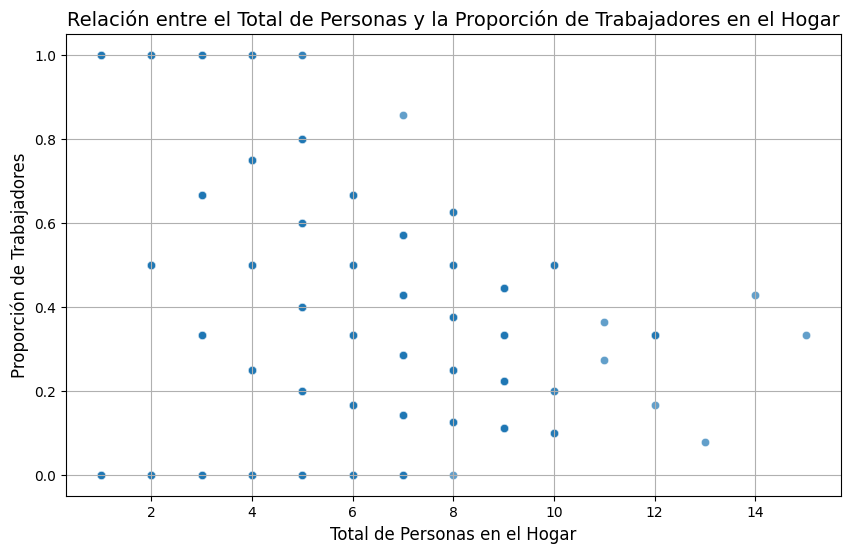

Total de filas: 3902
proporcion_trabajando
0.000    895
1.000    768
0.500    714
0.333    397
0.667    311
0.250    284
0.200    136
0.400    117
0.750     57
0.167     47
0.600     44
0.286     28
0.143     20
0.429     19
0.800     15
0.125     12
0.571      7
0.222      6
0.444      5
0.375      5
0.111      5
0.625      3
0.100      3
0.273      1
0.077      1
0.857      1
0.364      1
Name: count, dtype: int64
    total_personas  media_proporcion_trabajando  cantidad_hogares
0                1                     0.505190               867
1                2                     0.443669              1003
2                3                     0.495109               752
3                4                     0.413740               655
4                5                     0.349693               326
5                6                     0.326631               149
6                7                     0.300564                78
7                8                     0.287879     

In [26]:
# Asegurarnos de que cada hogar esté representado una sola vez
hogares_unicos = df_completa[['codusu', 'nro_hogar', 'proporcion_trabajando', 'total_personas']].drop_duplicates(subset=['codusu', 'nro_hogar'])

# Configurar el gráfico
plt.figure(figsize=(10, 6))

# Crear el scatter plot para ver la relación entre total de personas y proporción de trabajadores
sns.scatterplot(
    data=hogares_unicos,
    x='total_personas',
    y='proporcion_trabajando',
    alpha=0.7
)

# Agregar detalles al gráfico
plt.title('Relación entre el Total de Personas y la Proporción de Trabajadores en el Hogar', fontsize=14)
plt.xlabel('Total de Personas en el Hogar', fontsize=12)
plt.ylabel('Proporción de Trabajadores', fontsize=12)
plt.grid(True)
plt.show()


print("Total de filas:", hogares_unicos.shape[0])
print(hogares_unicos['proporcion_trabajando'].value_counts())

# 0.000 865: Significa que hay 865 hogares donde la proporción de personas que trabajan es 0 (es decir, nadie trabaja en esos hogares).

# Agrupar por total_personas y calcular la media de la proporcion_trabajando
tabla_resumen = hogares_unicos.groupby('total_personas').agg(
    media_proporcion_trabajando=('proporcion_trabajando', 'mean'),
    cantidad_hogares=('codusu', 'size')
).reset_index()

# Ordenar por total_personas para mayor claridad
tabla_resumen = tabla_resumen.sort_values(by='total_personas')

# Mostrar la tabla
print(tabla_resumen)

Frecuencias:
iv12_3
No     11250
Sí       226
0.0        3
Name: count, dtype: int64

Proporciones (%):
iv12_3
No     98.01
Sí      1.97
0.0     0.03
Name: proportion, dtype: float64


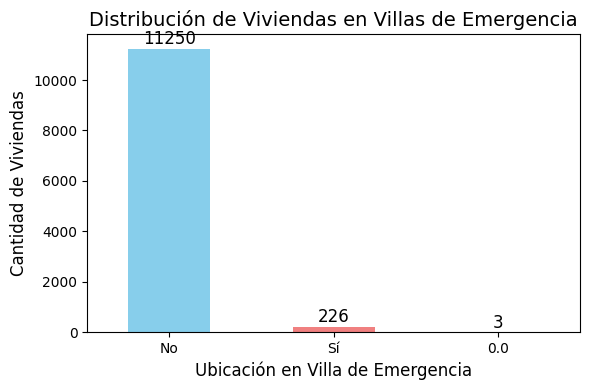

In [27]:
# Crear una copia temporal de la columna para trabajar
villa_observacion = df_completa['iv12_3'].replace({1: 'Sí', 2: 'No'})

# Calcular las frecuencias
frecuencias_villa = villa_observacion.value_counts()
print("Frecuencias:")
print(frecuencias_villa)

# Calcular las proporciones
proporciones_villa = villa_observacion.value_counts(normalize=True) * 100
print("\nProporciones (%):")
print(proporciones_villa.round(2))

plt.figure(figsize=(6, 4))
frecuencias_villa.plot(kind='bar', color=['skyblue', 'lightcoral'])

# Agregar título y etiquetas
plt.title('Distribución de Viviendas en Villas de Emergencia', fontsize=14)
plt.xlabel('Ubicación en Villa de Emergencia', fontsize=12)
plt.ylabel('Cantidad de Viviendas', fontsize=12)

# Mostrar los valores sobre las barras
for i, v in enumerate(frecuencias_villa):
    plt.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=12)

# Mostrar el gráfico
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# COMBINACION CON SI LA PERSONA TRABAJO ALGUNA VEZ

df_filtrado = df_completa[df_completa['pp10d'] != 0.0]

# Reemplazar los valores de IV12_3 N por etiquetas descriptivas (si no lo están ya)
df_filtrado['iv12_3'] = df_filtrado['iv12_3'].replace({1: 'Sí', 2: 'No'})

# Crear una tabla de contingencia para contar las frecuencias
contingencia = pd.crosstab(df_filtrado['iv12_3'], df_filtrado['pp10d'])

# Crear una tabla de porcentajes por fila
porcentajes = pd.crosstab(df_filtrado['iv12_3'], df_filtrado['pp10d'], normalize='index') * 100

In [28]:
# COMBINACION CON SI LA PERSONA TRABAJO ALGUNA VEZ

In [29]:
# V4 --> SEGURO DE DESEMPLEO

In [30]:
# ???? Falta una

### Clasificación y regularización

In [31]:
# USAR BASE RESPONDIERON. TENES QUE AGREGAR LOS DATOS QUE TIENE ESTA.

# IMPRIMI LAS COLUMNAS QUE ESTAN EN RESPONDIERON Y NO ESTAN EN COMPLETA Y MERGEA LAS QUE FALTAN SEGUN CODUSU Y NRO DE HOGAR 